# Kernelized Support Vector Machines
Matematično gledano gre za kompleksne modele

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

There are support vector machines for 
- classification (SVC)
- regression (SVR)

## Linear models and nonlinear features

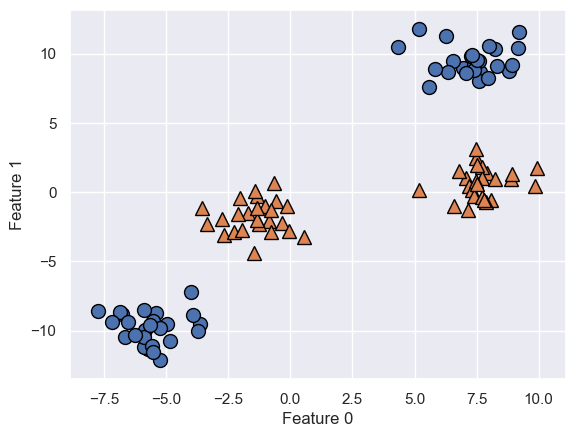

In [2]:
from helpers.plot_helpers import discrete_scatter
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)

y = y % 2

discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

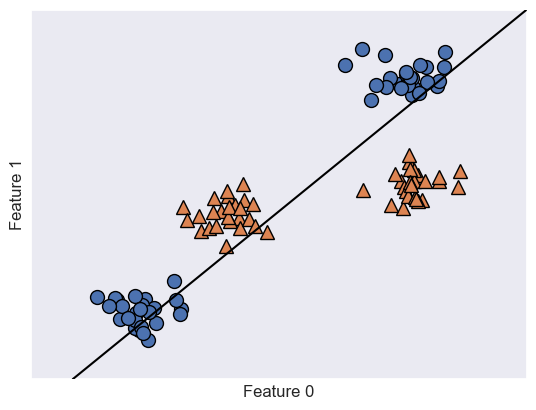

In [3]:
from sklearn.svm import LinearSVC
from helpers.plot_2d_separator import plot_2d_separator

linear_svm = LinearSVC(max_iter=10000).fit(X, y)

plot_2d_separator(linear_svm, X)
discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

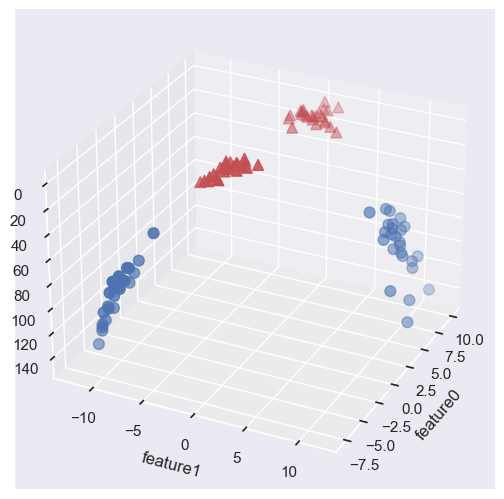

In [4]:
from mpl_toolkits.mplot3d import Axes3D, axes3d
from helpers import plot_helpers

# add the squared second feature
X_new = np.hstack([X, X[:, 1:] ** 2])
figure = plt.figure()

# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26, auto_add_to_figure=False)
figure.add_axes(ax)

# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")
plt.show()

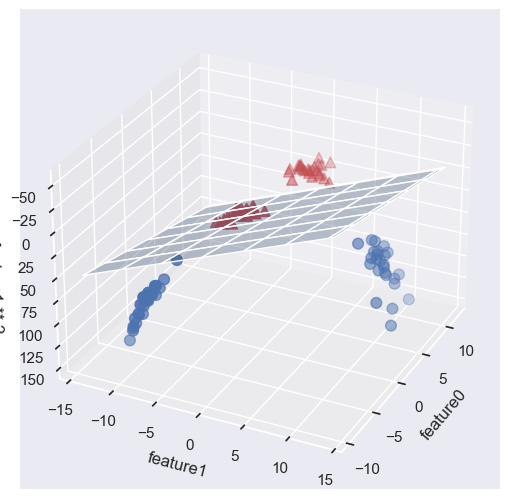

In [5]:
linear_svm_3d = LinearSVC(max_iter=10000).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26, auto_add_to_figure=False)
figure.add_axes(ax)

xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")
plt.show()

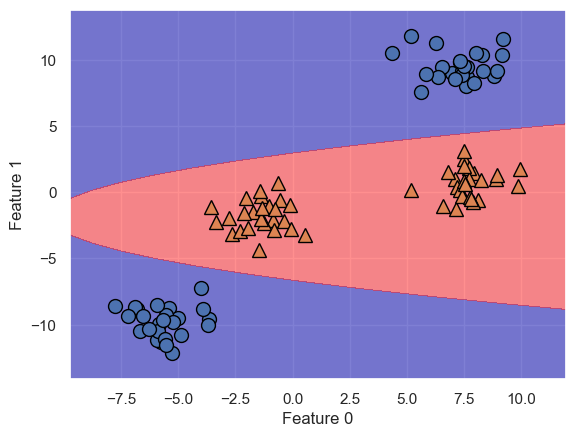

In [6]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],cmap=plot_helpers.cm2, alpha=0.5)
discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

## The kernel trick

## Understanding SVMs

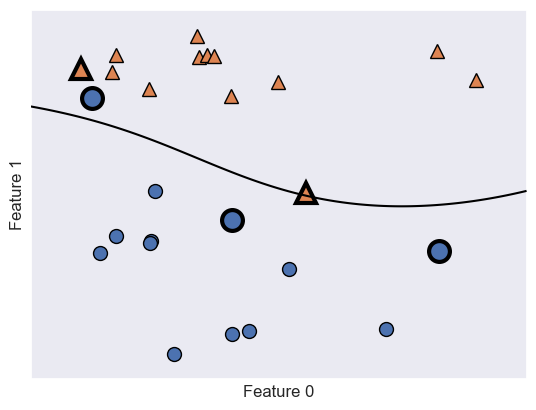

In [7]:
from helpers import tools
from sklearn.svm import SVC

X, y = tools.make_handcrafted_dataset()

svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

plot_2d_separator(svm, X, eps=.5)
discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0

discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# model določi glavne točke -> iz tega naredi support vectorje iz katerih naredi nelinearno mejo med območji
# na slikih so poudarjene točke s pomočjo katerih naredi linearno mejo

## Tuning SVM parameters

In [8]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [9]:
from ipywidgets import interact

X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)


def plot_svc(C=10, gamma=0.1):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
    model = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, ax)
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors='none');
    ax.set_title(f'C = {C}, gamma = {gamma}', size=14)


def plot_svc_interact():
    return interact(plot_svc, C=[0.01, 0.1, 0.5, 1, 5, 10, 50], gamma=[0.001, 0.01, 0.1, 1, 10])

plot_svc_interact()

# C -> regularizacija
# majhne vrednosti -> velika regularizacija


# gamma -> kako skupaj morajo biti točke, da jih zazna kot grupo ali pa uporabi kot kernel
# majhna gama -> velik radius kernela -> veliko ravne meje, vecja generalizacija
# velika gama -> majhni radiusi kernela -> kompleksni modeli, manjsa generalizacija

interactive(children=(Dropdown(description='C', index=5, options=(0.01, 0.1, 0.5, 1, 5, 10, 50), value=10), Dr…

<function __main__.plot_svc(C=10, gamma=0.1)>

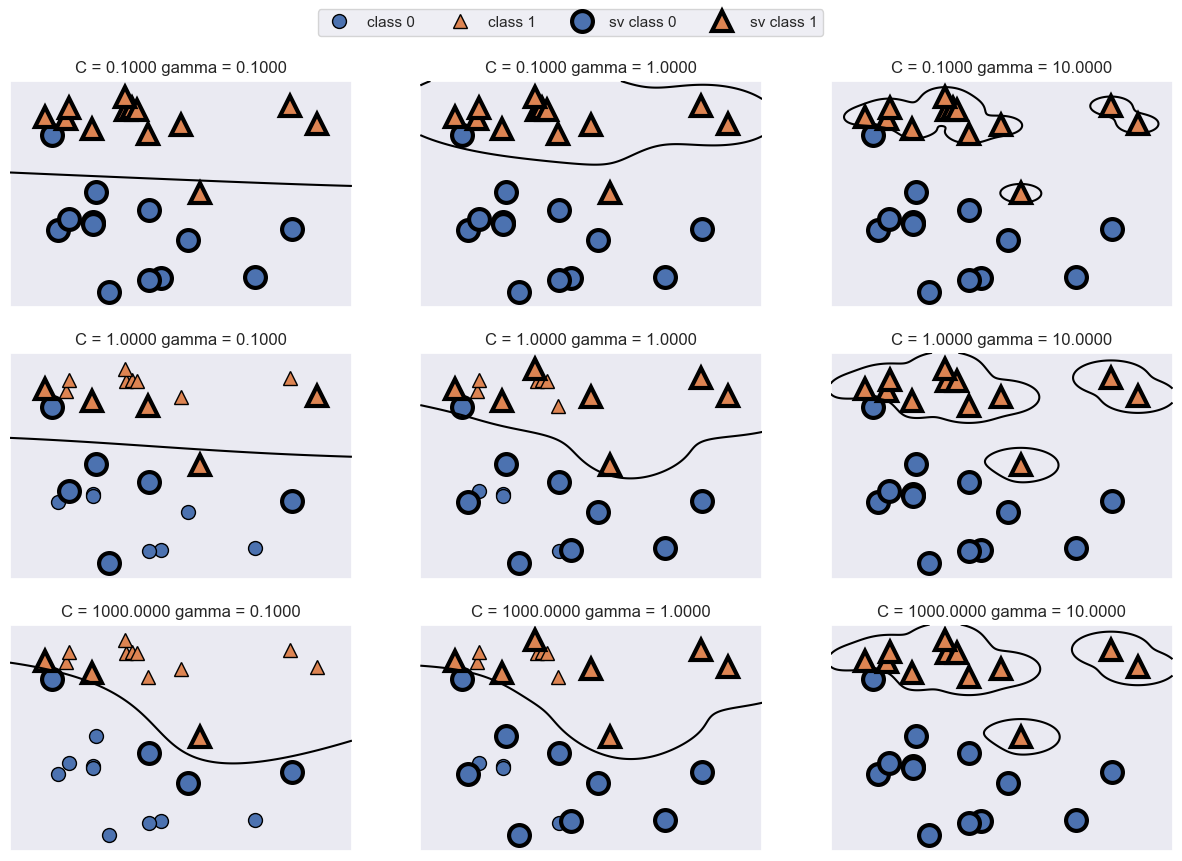

In [10]:
from helpers.plot_rbf_svm_parameters import plot_svm

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC(gamma="auto")
svc.fit(X_train, y_train)

print(f"Accuracy on training set: {svc.score(X_train, y_train):.2f}")
print(f"Accuracy on test set: {svc.score(X_test, y_test):.2f}")

# perfecten score na training setu -> pomeni da smo overfittali !
# SVM je zelo občutljiv na skaliranje in parametre
# v tem primeru namenoma nismo skalirali

Accuracy on training set: 1.00
Accuracy on test set: 0.63


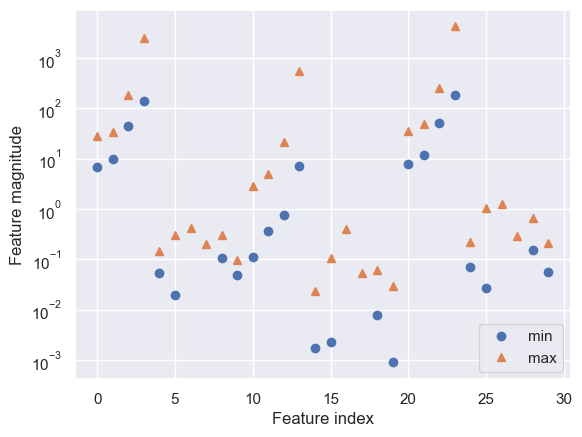

In [12]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")
plt.show()
# graf prikazuje magnitude neskaliranih podatkov

## Preprocessing data for SVMs

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
svc = SVC(gamma="auto")
svc.fit(X_train_scaled, y_train)

SVC(gamma='auto')

In [15]:
print(f"Accuracy on training set: {svc.score(X_train_scaled, y_train):.3f}")
print(f"Accuracy on test set: {svc.score(X_test_scaled, y_test):.3f}")

# če test set boljša ocena od training seta pomeni pa da smo underfittali !!!
# V sweet-spotu ima ponavadi test set malo manjšo vrednost

Accuracy on training set: 0.948
Accuracy on test set: 0.951


In [18]:
svc = SVC(C=1000, gamma="auto")
svc.fit(X_train_scaled, y_train)

print(f"Accuracy on training set: {svc.score(X_train_scaled, y_train):.3f}")
print(f"Accuracy on test set: {svc.score(X_test_scaled, y_test):.3f}")

Accuracy on training set: 0.988
Accuracy on test set: 0.972


## Strengths, weaknesses, and parameters

**Strengths:**
- Kernelized support vector machines are powerful models and perform well on a variety of datasets. 
- SVMs allow for complex decision boundaries, even if the data has only a few features. 
- They work well on low-dimensional and high-dimensional data (i.e.,few and many features), but 
- UPorabiti tudi za večje število značilk za primere:) Still, it might be worth trying SVMs, particularly if all of your features represent measurements in similar units (e.g., all are pixel intensities) and they are on similar scales.


**Weaknesses:**
- Don’t scale very well with the number of samples. 
    - Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.
- They require careful preprocessing of the data and tuning of the parameters.
    - This is why, these days, most people instead use tree-based models such as random forests or gradient boosting (which require little or no preprocessing) in many applications.
- SVM models are hard to inspect
    - It can be difficult to understand why a particular prediction was made, and it might be tricky to explain the model to a nonexpert.

**Parameters:**
- The important parameters in kernel SVMs are:
    - the regularization parameter C
    - the choice of the kernel (RBF)
    - the kernel-specific parameters
        - The RBF kernel has only one parameter, gamma, which is the inverse of the width of the Gaussian kernel. 
        
- gamma and C both control the complexity of the model, with large values in either resulting in a more complex model. 

- Therefore, good settings for the two parameters are usually strongly correlated, and C and gamma should be adjusted together.